In [1]:
!pip install -q -r ../requirements.txt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import dist

** Read Data**

---

In [3]:
# always explore reading and data a little bit tomake sure you read properly
train_in = pd.read_csv("train_in.csv",index_col=None,header=None)
im = train_in.iloc[0].values.reshape((16,16))
# plt.imshow(im)
train_in.shape,train_in.columns,train_in.index,im.shape


((1707, 256),
 Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
        ...
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255],
       dtype='int64', length=256),
 RangeIndex(start=0, stop=1707, step=1),
 (16, 16))

In [4]:
def no_index_read():
    def func(input:str):
        return pd.read_csv(input,index_col=None,header=None)
    return func
read_csv = no_index_read()

test_in = read_csv("test_in.csv")
test_out = read_csv("test_out.csv")
train_in = read_csv("train_in.csv")
train_out = read_csv("train_out.csv")
train_in.shape

(1707, 256)

**1.1**  

---
We have to:
- find centers
- calculate distances between centers
- explain what we expect about the accuracy of the model
- what pairs are most difficult to separate?
---


In [5]:
# CALCULATE CENTERS
digits = sorted(list(set(train_out.values.flatten())))
centers = {}
for d in digits:
    centers[d] = train_in.iloc[(train_out == d).values].mean(axis=0)

In [6]:
# CALCULATE DISTANCES BETWEEN CENTERS
distances = np.zeros((len(digits),len(digits)))
for d1 in digits:
    for d2 in digits:
        distances[d1,d2] = dist(centers[d1],centers[d2])

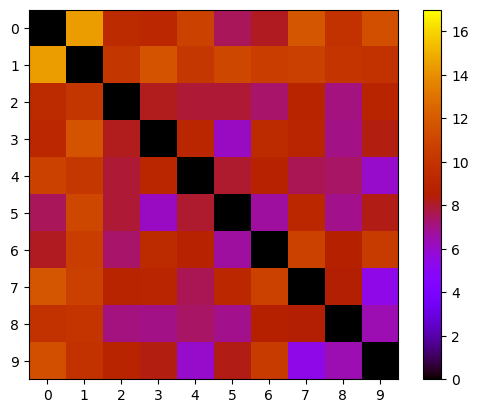

In [7]:
# VISUALIZE DISTANCES
plt.imshow(distances,cmap="gnuplot",vmax=17)
plt.xticks(digits)
plt.yticks(digits)
plt.colorbar()
plt.show()

Using this scale it is easy for us to notice similarities in the puple areas where the eucledian distance is low.
- 2 looks a bit like 6 or 8
- 3 is similar to 5 and a bit with 6
- 8 is similar with 2 3 5 and 9
- 9 is similar to 4 7 and 8
- 0 and 1 are very different between them so they will probably never get confused

**1.2**

---
Use:
- PCA
- U-MAP
- T-SNE
on the MNIST dataset
---

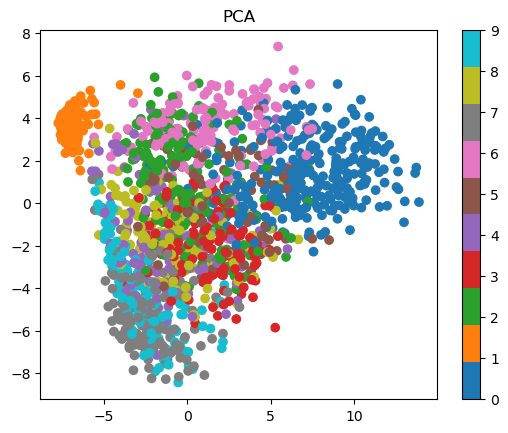

In [8]:
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

pca_2d = pca.fit_transform(train_in)
def plot2d(arr_2d,title):
    x = arr_2d[:,0]
    y = arr_2d[:,1]
    plt.scatter(x,y,c=train_out.values.flatten(),cmap="tab10")
    plt.colorbar()
    plt.title(title)
plot2d(pca_2d,"PCA")

We can see that PCA results create an overall non separable data distribution.
- 1 highly separable to the left
- 0 has a part that is away from anything else
- all the other numbers are blended with at least 2 other numbers

2024-09-21 18:09:10.030012: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-21 18:09:10.056088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-21 18:09:10.082601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-21 18:09:10.091921: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-21 18:09:10.115363: I tensorflow/core/platform/cpu_feature_guar

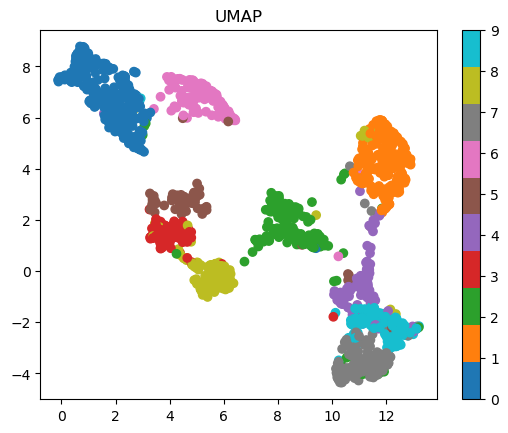

In [9]:
# UMAP
import umap
reducer = umap.UMAP()
umap_2d = reducer.fit_transform(train_in)
plot2d(umap_2d,"UMAP")
#~25sec

UMAP makes a much better job of gathering most of the items from a class close together
Some classes are still bounded close together
- 0 with 6
- 3,8,5 (part of what we expected from centers)
- 9,4,7 (same as what we expected from centers)
- 1 with some 4s
- 2 stands alone but in between everything



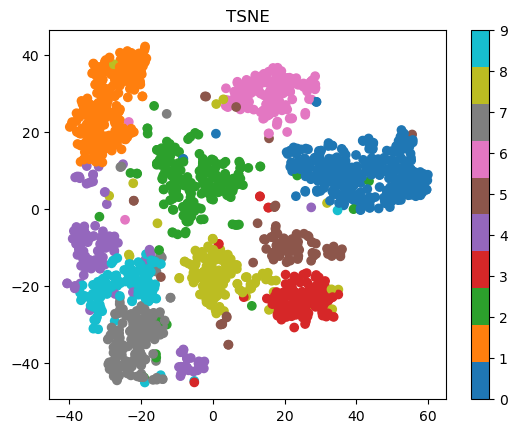

In [10]:
#T-SNE
from sklearn.manifold import TSNE
reducer = TSNE()
tsne_2d = reducer.fit_transform(train_in)
plot2d(tsne_2d,"TSNE")
#~12 sec

Similar results with UMAP but manages to separate 6 with 0
- 1 alone (again with little amount of 4s)
- 4,9,7 ( like centers )
- 2 in the middle
- 3,5,8 (bottom right, like centers)
- 0 to the right
- 6 at the top

**1.3**

---

Nearest mean classifier using the centers from 1.1

---

In [11]:
def nearest_mean_classifier(row):
    min = float("inf")
    closest = -1
    for d,center in centers.items():
        distance = dist(row.values.flatten(),center)
        if distance<min:
            min = distance
            closest = d
    return closest

def predict(x):
    y = pd.DataFrame(data = {0: [i]*len(x) for i in range(1)})
    for i,row in x.iterrows():
        d = nearest_mean_classifier(row)
        y.iloc[i] = int(d)
    return y
y = predict(train_in)


In [34]:
from sklearn.metrics import accuracy_score

def calc_accuracy(y_true,y_pred,text=""):
    accuracy = accuracy_score(y_true,y_pred)
    a = "a" if len(text) else "A"
    print(f"{text} {a}ccuracy: {100*accuracy:.2f}%")
    return y_true,y_pred
y_true,y_pred = calc_accuracy(train_out,y,)

 Accuracy: 86.35%


<Axes: title={'center': 'Errors for each class'}, xlabel='0'>

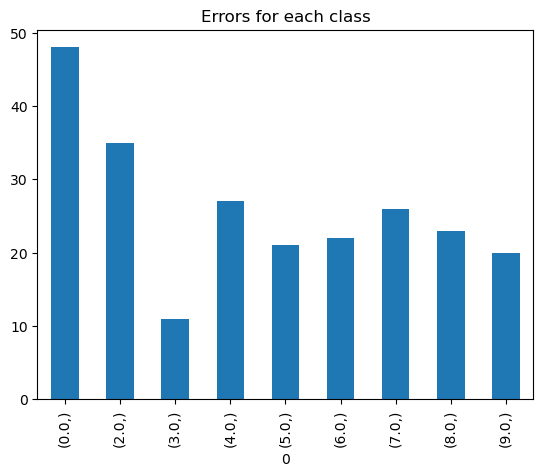

In [35]:
train_out[y_pred!=y_true].value_counts().sort_index().plot.bar(title="Errors for each class")

Resulting Accuracy 86.35%
no mistakes for 1
most mistakes for 0

<Axes: title={'center': 'Overall items in each class'}, xlabel='0'>

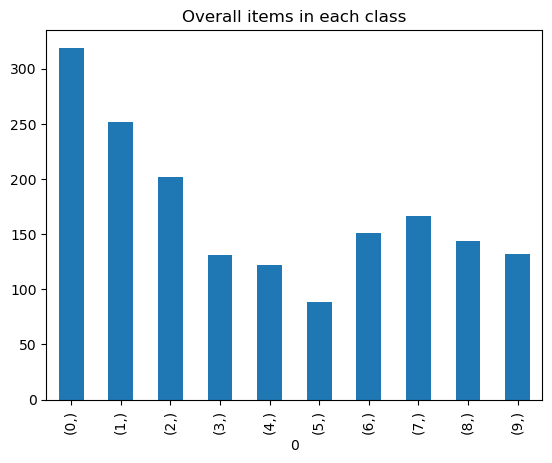

In [36]:
train_out.value_counts().sort_index().plot.bar(title = "Overall items in each class")

So apparently our data have way more 0 than the other letters so high number of 0 errors is also attributed to their prevalance in the datset

--- 
Now for the test set

---

In [37]:
y_test = predict(test_in)
y_true_test,y_pred_test = calc_accuracy(test_out,y_test)

 Accuracy: 80.40%


Well aparently the test set is a bit different from the train set and the accuracy falls
in the graphic below we can see that there are errors for all digits, even in the case of 1 for which our classifier had no errors on the training set.

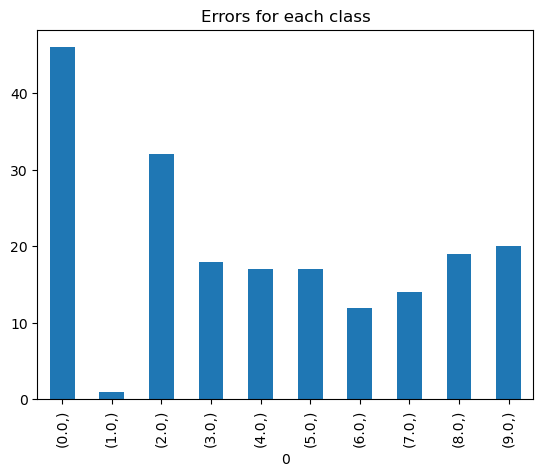

In [46]:
test_out[y_pred_test!=y_true_test].value_counts().sort_index().plot.bar(title="Errors for each class")
plt.show()

**1.3**

---

KNN classifier

---

In [39]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_in,train_out.values.flatten())
y_pred_knn = knn.predict(train_in)
y_test_pred_knn = knn.predict(test_in)
acc_knn_tran = calc_accuracy(train_out,y_pred_knn,"Train")
acc_knn_test = calc_accuracy(test_out,y_test_pred_knn,"Test")

Train accuracy: 96.60%
Test accuracy: 90.80%


In [40]:
from sklearn.metrics import confusion_matrix
n = "true"
    
center_cm = confusion_matrix(y_true,y_pred,normalize=n)
center_cm_test = confusion_matrix(y_true_test,y_pred_test,normalize=n)
knn_cm = confusion_matrix(y_true,y_pred_knn,normalize=n)
knn_cm_test = confusion_matrix(y_true_test,y_test_pred_knn,normalize=n)



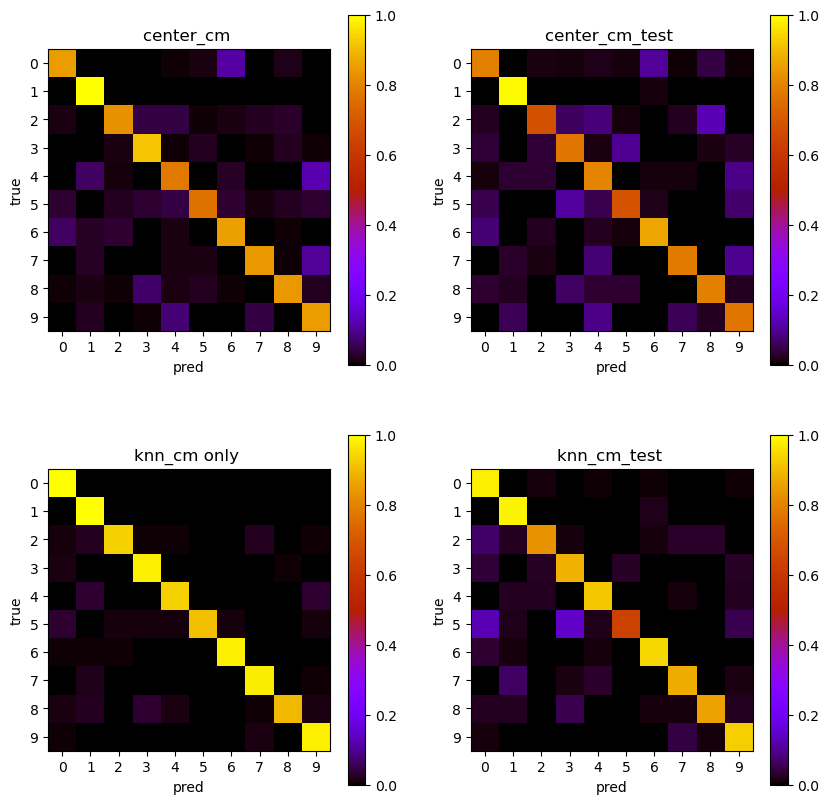

In [41]:
def plot_cm(cm,title="",clim=None,**kwargs):
    plt.imshow(cm,cmap="gnuplot",**kwargs)
    plt.xticks(digits)
    plt.yticks(digits)
    plt.xlabel('pred')
    plt.ylabel('true')
    plt.title(title)
    plt.colorbar()

def plot_cms(mode="",**kwargs):
    plt.figure(figsize=(10,10))
    r,c = 2,2
    plt.subplot(r,c,1)
    plot_cm(center_cm,f"center_cm {mode}",**kwargs)
    plt.subplot(r,c,2)
    plot_cm(center_cm_test,f"center_cm_test {mode}",**kwargs)
    plt.subplot(r,c,3)
    plot_cm(knn_cm,f"knn_cm only {mode}",**kwargs)
    plt.subplot(r,c,4)
    plot_cm(knn_cm_test,f"knn_cm_test {mode}",**kwargs)
plot_cms(vmax=1)

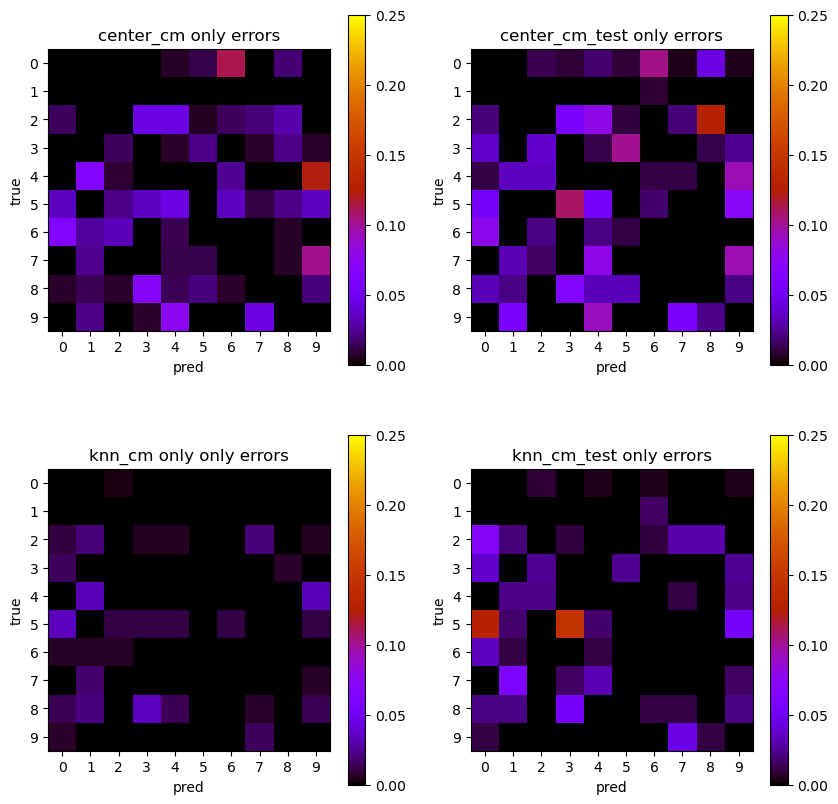

In [42]:
# PLOT ONLY ERRORS FROM CM
np.fill_diagonal(center_cm  ,0)
np.fill_diagonal(center_cm_test,0)
np.fill_diagonal(knn_cm,0)
np.fill_diagonal(knn_cm_test,0)

plot_cms(mode="only errors",vmax=0.25)


Overall we can see that these models are doing pretty well when they are applied on the train set but the accuracy decreases when applied on the test set.
We can see from the confusion matrix that the single center algorithm has error for almost all the numbers but especially for the pairs (6-0) (4-9) and (7-9)
The knn algorithm on the other hand does not have as many errors but it has a very hard time recognizing 5 from a 0 or a 3